In [40]:
import pandas as pd 
import numpy as np
import plotly.express as px
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import stattools
import statsmodels.api as sm
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from itertools import product



In [41]:
df = pd.read_csv("/Users/asyzyni/Desktop/Car-Sales-Forecasting/car_registrations_2021_2025.csv")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.head()

,value
date,
2021-01-01,52909
2021-02-01,49202
2021-03-01,84915
2021-04-01,78908
2021-05-01,54812


cek line plot car

In [42]:
# plot garis time series data

fig = px.line(df,y='value',x=df.index, title='car registrations over time')

fig.show()

/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



# Uji Stasioneritas pada data full

In [43]:
def adf_test(series, title=''):
    result = stattools.adfuller(series.dropna(), autolag='AIC')
    p_value = result[1]
    is_stationary = p_value <= 0.05
    
    print("-"*50)
    print(f'Augmented Dickey-Fuller Test: {title}')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {p_value:.4f}')
    print(f"critical values:")
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    if is_stationary:
        print(f"=> The series is stationary.( {p_value:.4f} <= 0.05 )")
    else:
        print(f"=> The series is non-stationary.( {p_value:.4f} > 0.05 )")
    
    return is_stationary, p_value

is_stationary, p_value = adf_test(df['value'], title='Car Registrations')

--------------------------------------------------
Augmented Dickey-Fuller Test: Car Registrations
ADF Statistic: -2.1590
p-value: 0.2215
critical values:
	1%: -3.5529
	5%: -2.9147
	10%: -2.5951
=> The series is non-stationary.( 0.2215 > 0.05 )


# Split Data Train-Test

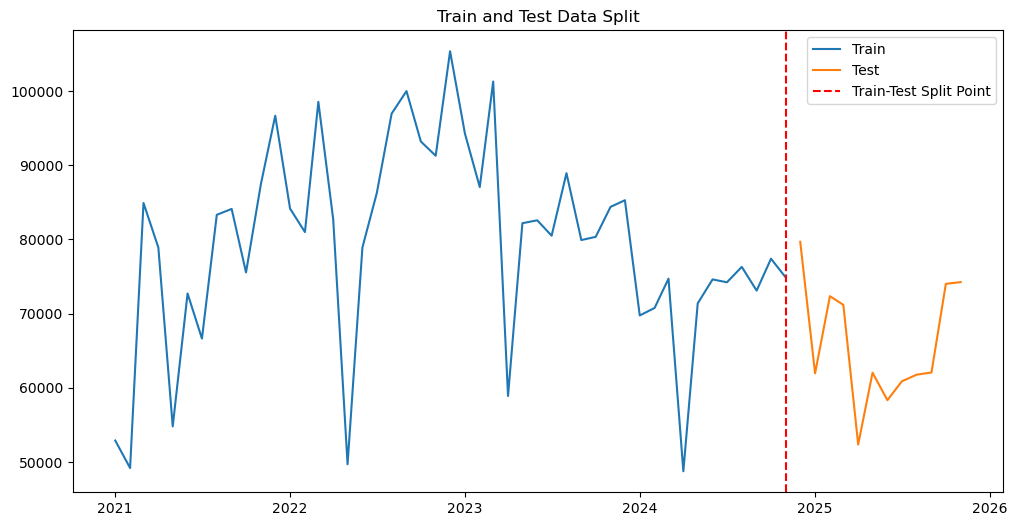

In [44]:
train = df.iloc[:-12]
test  = df.iloc[-12:]

# visualisasi data train dan test
plt.figure(figsize=(12,6))
plt.plot(train['value'], label='Train')
plt.plot(test['value'], label='Test')
plt.axvline(x=train.index[-1], color='r', linestyle='--', label='Train-Test Split Point')
plt.legend()
plt.title('Train and Test Data Split')
plt.show()

# Uji Stasioneritas pada Train

In [45]:
print("============================ Original Series ============================")
adf_ori, p_val_ori = adf_test(df['value'], title='Original Series')

print("\n============================ 1st Differencing (d=1 D=0) ============================")
train_diff1 = train['value'].diff().dropna()
adf_diff1, p_val_diff1 = adf_test(train_diff1, title='1st Differencing') 

print("\n============================ Seasonal Differencing (d=0 D=1) ============================")
train_diff2 = train_diff1.diff().dropna()
adf_diff2, p_val_diff2 = adf_test(train_diff2, title='Seasonal Differencing')
print("\n============================ 1st Differencing + Seasonal Differencing (d=1 D=1) ============================")
train_diff3 = train['value'].diff().diff(12).dropna()
adf_diff3, p_val_diff3 = adf_test(train_diff3, title='1st Differencing + Seasonal Differencing')



============================ Original Series ============================
--------------------------------------------------
Augmented Dickey-Fuller Test: Original Series
ADF Statistic: -2.1590
p-value: 0.2215
critical values:
	1%: -3.5529
	5%: -2.9147
	10%: -2.5951
=> The series is non-stationary.( 0.2215 > 0.05 )

============================ 1st Differencing (d=1 D=0) ============================
--------------------------------------------------
Augmented Dickey-Fuller Test: 1st Differencing
ADF Statistic: -8.6734
p-value: 0.0000
critical values:
	1%: -3.5886
	5%: -2.9299
	10%: -2.6032
=> The series is stationary.( 0.0000 <= 0.05 )

============================ Seasonal Differencing (d=0 D=1) ============================
--------------------------------------------------
Augmented Dickey-Fuller Test: Seasonal Differencing
ADF Statistic: -5.5389
p-value: 0.0000
critical values:
	1%: -3.6392
	5%: -2.9512
	10%: -2.6144
=> The series is stationary.( 0.0000 <= 0.05 )

==================

In [46]:
if adf_ori :
    d_optimal, D_optimal = 0, 0
elif adf_diff1 :
    d_optimal, D_optimal = 1, 0
elif adf_diff2 :
    d_optimal, D_optimal = 0, 1
elif adf_diff3 :
    d_optimal, D_optimal = 1, 1
else :
    d_optimal, D_optimal = 1, 1  # default to (1,1) if none are stationary  
    
print(f"Optimal differencing orders: d = {d_optimal}, D = {D_optimal}")

Optimal differencing orders: d = 1, D = 0


# Plot ACF/PACF Train


============================ ACF and PACF Plots (1st Differencing) ============================


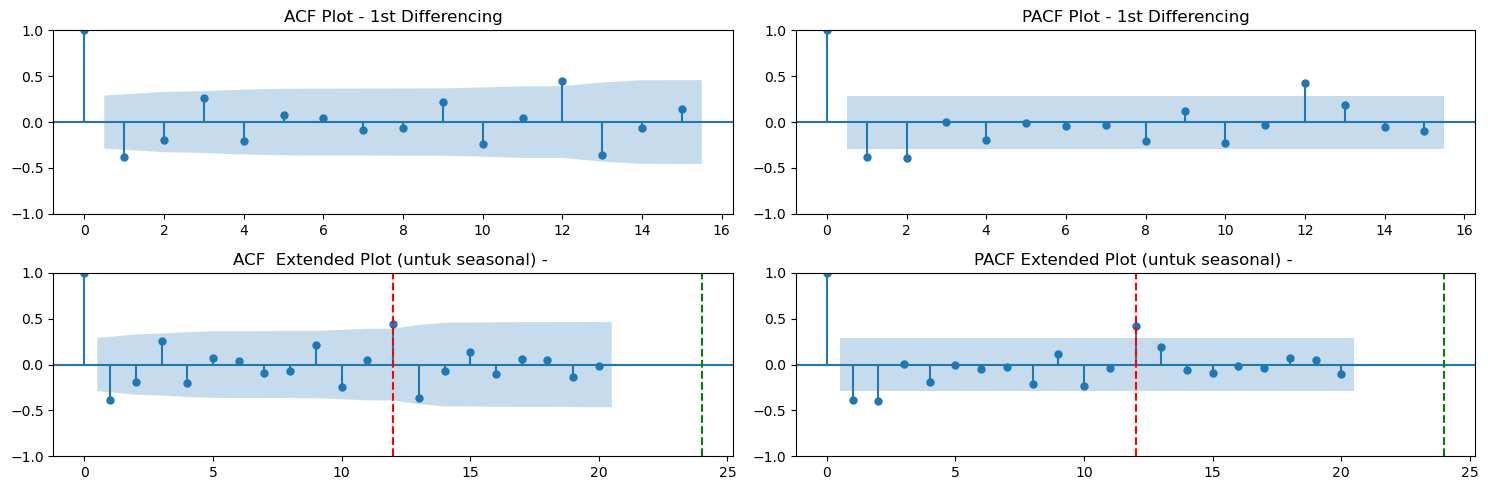

In [47]:
if d_optimal == 1 and D_optimal == 0:
    train_stationary = train_diff1.dropna()
    title = '1st Differencing'
elif d_optimal == 0 and D_optimal == 1:
    train_stationary = train_diff2.dropna()
    title = 'Seasonal Differencing'
elif d_optimal == 1 and D_optimal == 1:
    train_stationary = train_diff3.dropna()
    title = '1st Differencing + Seasonal Differencing'
else:
    train_stationary = train['value']
    title = 'Original Series'   

print(f"\n============================ ACF and PACF Plots ({title}) ============================")
fig, ax = plt.subplots(2, 2, figsize=(15,5))    
plot_acf(train_stationary, lags=15, ax=ax[0,0], title='ACF Plot - ' + title)
plot_pacf(train_stationary, lags=15, ax=ax[0,1], title='PACF Plot - ' + title)

plot_acf(train_stationary, lags=(min(20, len(train_stationary)//2-1)), ax=ax[1,0], title='ACF  Extended Plot (untuk seasonal) - ')
plot_pacf(train_stationary, lags=(min(20, len(train_stationary)//2-1)), ax=ax[1,1], title='PACF Extended Plot (untuk seasonal) - ')

for ax in ax[1,:]:
    ax.axvline(x=12, color='r', linestyle='--', label='Lag 12 (Seasonality)')
    ax.axvline(x=24, color='g', linestyle='--', label='Lag 24 (Seasonality)')
plt.tight_layout()
plt.show()

# Feature Engineering

In [48]:
def create_features(df, target_column='value'):
    """Buat fitur dari data"""
    df = df.copy()
    
    # LAG FEATURES
    for lag in [1, 2, 3, 6]:
        df[f'lag_{lag}'] = df[target_column].shift(lag)
    df['lag_12'] = df[target_column].shift(12)
    df['lag_24'] = df[target_column].shift(24)
    
    # ROLLING STATISTICS
    df['rolling_mean_3'] = df[target_column].shift().rolling(window=3).mean()
    df['rolling_std_3'] = df[target_column].shift().rolling(window=3).std()
    df['rolling_mean_6'] = df[target_column].shift().rolling(window=6).mean()
    df['rolling_std_6'] = df[target_column].shift().rolling(window=6).std()
    df['rolling_mean_12'] = df[target_column].shift().rolling(window=12).mean()
    df['rolling_std_12'] = df[target_column].shift().rolling(window=12).std()
    
    # CYCLICAL FEATURES
    df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)
    df['quarter_sin'] = np.sin(2 * np.pi * df.index.quarter / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * df.index.quarter / 4)
    
    # SEASONAL INDICATORS
    df['is_q1'] = (df.index.quarter == 1).astype(int)
    df['is_q2'] = (df.index.quarter == 2).astype(int)
    df['is_q3'] = (df.index.quarter == 3).astype(int)
    df['is_q4'] = (df.index.quarter == 4).astype(int)
    df['is_year_start'] = (df.index.month <= 2).astype(int)
    df['is_year_end'] = (df.index.month >= 11).astype(int)
    df['is_mid_year'] = (df.index.month.isin([6, 7, 8])).astype(int)
    
    return df

# Hitung parameter imputasi HANYA DARI TRAIN
print("Menghitung parameter imputasi dari TRAIN...")

# Monthly average dari TRAIN saja
monthly_avg_train = train.groupby(train.index.month)['value'].mean().to_dict()
overall_std_train = train['value'].std()

print("\nMonthly Average (dari TRAIN):")
for month, avg in monthly_avg_train.items():
    print(f"  Bulan {month:2d}: {avg:,.2f}")
print(f"\nOverall Std (dari TRAIN): {overall_std_train:,.2f}")

Menghitung parameter imputasi dari TRAIN...

Monthly Average (dari TRAIN):
  Bulan  1: 75,271.50
  Bulan  2: 72,007.00
  Bulan  3: 89,860.50
  Bulan  4: 67,328.00
  Bulan  5: 64,525.75
  Bulan  6: 77,206.75
  Bulan  7: 76,904.50
  Bulan  8: 86,376.25
  Bulan  9: 84,281.50
  Bulan 10: 81,626.50
  Bulan 11: 84,488.75
  Bulan 12: 95,770.33

Overall Std (dari TRAIN): 13,675.62


In [49]:
def impute_nan_with_train_params(df, monthly_avg, overall_std, target_column='value'):
    """Imputasi NaN menggunakan parameter dari training data"""
    df_imp = df.copy()
    
    # Imputasi lag
    lag_cols = [c for c in df_imp.columns if c.startswith('lag_')]
    for col in lag_cols:
        for idx in df_imp[df_imp[col].isna()].index:
            month = idx.month
            df_imp.loc[idx, col] = monthly_avg.get(month, np.mean(list(monthly_avg.values())))
    
    # Imputasi rolling mean
    rolling_mean_cols = [c for c in df_imp.columns if 'rolling_mean' in c]
    for col in rolling_mean_cols:
        for idx in df_imp[df_imp[col].isna()].index:
            month = idx.month
            df_imp.loc[idx, col] = monthly_avg.get(month, np.mean(list(monthly_avg.values())))
    
    # Imputasi rolling std
    rolling_std_cols = [c for c in df_imp.columns if 'rolling_std' in c]
    for col in rolling_std_cols:
        df_imp[col] = df_imp[col].fillna(overall_std)
    
    return df_imp

# Terapkan feature engineering
train_featured = create_features(train)
test_featured = create_features(test)

# Imputasi dengan parameter dari TRAIN
train_clean = impute_nan_with_train_params(train_featured, monthly_avg_train, overall_std_train)
test_clean = impute_nan_with_train_params(test_featured, monthly_avg_train, overall_std_train)

print(f"\nTrain NaN setelah imputasi: {train_clean.isnull().sum().sum()}")
print(f"Test NaN setelah imputasi: {test_clean.isnull().sum().sum()}")


Train NaN setelah imputasi: 0
Test NaN setelah imputasi: 0


In [50]:
train_clean.head()

,value,lag_1,lag_2,lag_3,lag_6,lag_12,lag_24,rolling_mean_3,rolling_std_3,rolling_mean_6,...,month_cos,quarter_sin,quarter_cos,is_q1,is_q2,is_q3,is_q4,is_year_start,is_year_end,is_mid_year
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,52909,75271.5,75271.5,75271.5,75271.50,75271.50,75271.50,75271.500000,13675.624444,75271.50,...,8.660254e-01,1.000000e+00,6.123234e-17,1,0,0,0,1,0,0
2021-02-01,49202,52909.0,72007.0,72007.0,72007.00,72007.00,72007.00,72007.000000,13675.624444,72007.00,...,5.000000e-01,1.000000e+00,6.123234e-17,1,0,0,0,1,0,0
2021-03-01,84915,49202.0,52909.0,89860.5,89860.50,89860.50,89860.50,89860.500000,13675.624444,89860.50,...,6.123234e-17,1.000000e+00,6.123234e-17,1,0,0,0,0,0,0
2021-04-01,78908,84915.0,49202.0,52909.0,67328.00,67328.00,67328.00,62342.000000,19636.463760,67328.00,...,-5.000000e-01,1.224647e-16,-1.000000e+00,0,1,0,0,0,0,0
2021-05-01,54812,78908.0,84915.0,49202.0,64525.75,64525.75,64525.75,71008.333333,19122.189789,64525.75,...,-8.660254e-01,1.224647e-16,-1.000000e+00,0,1,0,0,0,0,0


# Data Preparation for Modeling

In [51]:
exog_columns = [
    'lag_1', 'lag_2', 'lag_3', 'lag_12',
    'rolling_mean_3', 'rolling_mean_12',
    'month_sin', 'month_cos',
    'is_q1', 'is_q4'
]

# Target dan Exogenous
train_y = train_clean['value']
test_y = test_clean['value']
train_X = train_clean[exog_columns]
test_X = test_clean[exog_columns]

print(f"Train: {len(train_y)} observations")
print(f"Test:  {len(test_y)} observations")
print(f"Exogenous features: {len(exog_columns)}")


Train: 47 observations
Test:  12 observations
Exogenous features: 10


# Grid Search 

In [52]:
# Range parameter berdasarkan analisis ACF/PACF (dari TRAIN)
p_range = [0, 1, 2]
d_range = [d_optimal]
q_range = [0, 1, 2]
P_range = [0, 1]
D_range = [D_optimal]
Q_range = [0, 1]
s = 12

res = []
total = len(p_range) * len(d_range) * len(q_range) * len(P_range) * len(D_range) * len(Q_range)
current = 0 

print(f"Total kombinasi parameter yang akan diuji: {total}")

for p, q, P, Q in product(p_range, q_range, P_range, Q_range):
    current += 1
    order = (p, d_optimal, q)
    seasonal_order = (P, D_optimal, Q, s)
    
    try:
        model = SARIMAX(
            train_y,
            exog=train_X,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False, 
            enforce_invertibility=False
        )
        
        fitted = model.fit(disp=False, maxiter=200)
        
        forecast = fitted.get_forecast(steps=len(test_X), exog=test_X)
        
        # metrics
        aic = fitted.aic
        bic = fitted.bic
        rmse = np.sqrt(mean_squared_error(test_y, forecast.predicted_mean))
        mape = mean_absolute_percentage_error(test_y, forecast.predicted_mean)
        
        res.append({
            'order': order,
            'seasonal_order': seasonal_order,
            'AIC': aic,
            'BIC': bic,
            'RMSE': rmse,
            'MAPE': mape
        })
        
        print(f"[{current:2d}/{total}] SARIMAX{order}{seasonal_order} | "f"AIC: {aic:,.0f} | RMSE: {rmse:,.0f} | MAPE: {mape*100:.2f}%")
    
    except Exception as e:
        print(f"[{current:2d}/{total}] SARIMAX{order}{seasonal_order} | Error: {str(e)[:30]}")
        

# hasil 
results_df = pd.DataFrame(res).sort_values(by=['AIC', 'RMSE']).reset_index(drop=True)
results_df.head(5)

Total kombinasi parameter yang akan diuji: 36


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[ 1/36] SARIMAX(0, 1, 0)(0, 0, 0, 12) | AIC: 978 | RMSE: 15,977 | MAPE: 21.80%
[ 2/36] SARIMAX(0, 1, 0)(0, 0, 1, 12) | AIC: 3,620 | RMSE: 28,661 | MAPE: 39.53%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[ 3/36] SARIMAX(0, 1, 0)(1, 0, 0, 12) | AIC: 736 | RMSE: 15,910 | MAPE: 22.47%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[ 4/36] SARIMAX(0, 1, 0)(1, 0, 1, 12) | AIC: 3,620 | RMSE: 28,632 | MAPE: 39.53%
[ 5/36] SARIMAX(0, 1, 1)(0, 0, 0, 12) | AIC: 943 | RMSE: 13,617 | MAPE: 18.84%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[ 6/36] SARIMAX(0, 1, 1)(0, 0, 1, 12) | AIC: 1,854 | RMSE: 2,329,293,897,048 | MAPE: 3583441496.44%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[ 7/36] SARIMAX(0, 1, 1)(1, 0, 0, 12) | AIC: 736 | RMSE: 16,587 | MAPE: 22.19%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[ 8/36] SARIMAX(0, 1, 1)(1, 0, 1, 12) | AIC: 2,001 | RMSE: 9,833,800,657,735,868 | MAPE: 8430678829238.35%
[ 9/36] SARIMAX(0, 1, 2)(0, 0, 0, 12) | AIC: 922 | RMSE: 12,087 | MAPE: 16.47%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[10/36] SARIMAX(0, 1, 2)(0, 0, 1, 12) | AIC: 2,042 | RMSE: 2,208,295 | MAPE: 3396.83%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[11/36] SARIMAX(0, 1, 2)(1, 0, 0, 12) | AIC: 734 | RMSE: 18,142 | MAPE: 24.10%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[12/36] SARIMAX(0, 1, 2)(1, 0, 1, 12) | AIC: 1,309 | RMSE: 28,373,044,410,626,680 | MAPE: 38739152037219.63%
[13/36] SARIMAX(1, 1, 0)(0, 0, 0, 12) | AIC: 978 | RMSE: 14,056 | MAPE: 19.18%
[14/36] SARIMAX(1, 1, 0)(0, 0, 1, 12) | AIC: 3,573 | RMSE: 45,759 | MAPE: 64.42%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency info

[15/36] SARIMAX(1, 1, 0)(1, 0, 0, 12) | AIC: 716 | RMSE: 17,666 | MAPE: 23.22%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[16/36] SARIMAX(1, 1, 0)(1, 0, 1, 12) | AIC: 3,579 | RMSE: 151,863,856,591 | MAPE: 167294659.87%
[17/36] SARIMAX(1, 1, 1)(0, 0, 0, 12) | AIC: 944 | RMSE: 13,530 | MAPE: 18.93%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[18/36] SARIMAX(1, 1, 1)(0, 0, 1, 12) | AIC: 2,086 | RMSE: 216,938,718,923,831 | MAPE: 333743718854.23%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[19/36] SARIMAX(1, 1, 1)(1, 0, 0, 12) | AIC: 716 | RMSE: 20,109 | MAPE: 26.94%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[20/36] SARIMAX(1, 1, 1)(1, 0, 1, 12) | AIC: 2,468 | RMSE: 30,488,765,548,125 | MAPE: 42984091095.72%
[21/36] SARIMAX(1, 1, 2)(0, 0, 0, 12) | AIC: 924 | RMSE: 12,114 | MAPE: 16.50%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information wa

[22/36] SARIMAX(1, 1, 2)(0, 0, 1, 12) | AIC: 2,559 | RMSE: 5,303,045,069 | MAPE: 8163990.80%
[23/36] SARIMAX(1, 1, 2)(1, 0, 0, 12) | AIC: 718 | RMSE: 20,148 | MAPE: 26.49%
[24/36] SARIMAX(1, 1, 2)(1, 0, 1, 12) | AIC: 2,463 | RMSE: 6,255,865,867,392,801 | MAPE: 4127049185302.96%
[25/36] SARIMAX(2, 1, 0)(0, 0, 0, 12) | AIC: 945 | RMSE: 13,263 | MAPE: 18.41%
[26/36] SARIMAX(2, 1, 0)(0, 0, 1, 12) | AIC: 3,532 | RMSE: 25,707 | MAPE: 36.84%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency info

[27/36] SARIMAX(2, 1, 0)(1, 0, 0, 12) | AIC: 693 | RMSE: 24,128 | MAPE: 32.01%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[28/36] SARIMAX(2, 1, 0)(1, 0, 1, 12) | AIC: 2,555 | RMSE: 23,724 | MAPE: 33.96%
[29/36] SARIMAX(2, 1, 1)(0, 0, 0, 12) | AIC: 943 | RMSE: 13,303 | MAPE: 18.06%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information wa

[30/36] SARIMAX(2, 1, 1)(0, 0, 1, 12) | AIC: 2,729 | RMSE: 15,957,538,487 | MAPE: 23744644.25%
[31/36] SARIMAX(2, 1, 1)(1, 0, 0, 12) | AIC: 691 | RMSE: 25,477 | MAPE: 33.27%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[32/36] SARIMAX(2, 1, 1)(1, 0, 1, 12) | AIC: 2,725 | RMSE: 17,178,023,359 | MAPE: 25678373.92%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[33/36] SARIMAX(2, 1, 2)(0, 0, 0, 12) | AIC: 915 | RMSE: 15,718 | MAPE: 21.45%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[34/36] SARIMAX(2, 1, 2)(0, 0, 1, 12) | AIC: 2,499 | RMSE: 17,575,122,513,072 | MAPE: 26842679106.31%
[35/36] SARIMAX(2, 1, 2)(1, 0, 0, 12) | AIC: 689 | RMSE: 16,285 | MAPE: 22.91%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[36/36] SARIMAX(2, 1, 2)(1, 0, 1, 12) | AIC: 2,495 | RMSE: 865,011,403,365 | MAPE: 1292111981.00%


,order,seasonal_order,AIC,BIC,RMSE,MAPE
0,"(2, 1, 2)","(1, 0, 0, 12)",688.795800,712.247575,16285.440410,0.229138
1,"(2, 1, 1)","(1, 0, 0, 12)",690.730209,712.716248,25476.651974,0.332706
2,"(2, 1, 0)","(1, 0, 0, 12)",692.875676,713.395979,24128.276508,0.320081
3,"(1, 1, 1)","(1, 0, 0, 12)",715.523545,736.474651,20108.840019,0.269353
4,"(1, 1, 0)","(1, 0, 0, 12)",716.324397,735.778995,17666.440487,0.232188


In [53]:
# Model terbaik
best_model_info = results_df.iloc[0]
best_order = best_model_info['order']
best_seasonal_order = best_model_info['seasonal_order']

print("\n" + "-" * 50)
print("🏆 MODEL TERBAIK:")
print("-" * 50)
print(f"   Order: SARIMAX{best_order}{best_seasonal_order}")
print(f"   AIC:   {best_model_info['AIC']:,.2f}")
print(f"   BIC:   {best_model_info['BIC']:,.2f}")
print(f"   RMSE:  {best_model_info['RMSE']:,.2f}")
print(f"   MAPE:  {best_model_info['MAPE']:.2f}%")


--------------------------------------------------
🏆 MODEL TERBAIK:
--------------------------------------------------
   Order: SARIMAX(2, 1, 2)(1, 0, 0, 12)
   AIC:   688.80
   BIC:   712.25
   RMSE:  16,285.44
   MAPE:  0.23%


In [54]:
# Fit ulang model terbaik untuk diagnostics
best_model = SARIMAX(
    train_y,
    exog=train_X,
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
best_fitted = best_model.fit(disp=False)

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [55]:
best_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               value   No. Observations:                   47
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 12)   Log Likelihood                -328.398
Date:                             Sun, 04 Jan 2026   AIC                            688.796
Time:                                     21:39:45   BIC                            712.248
Sample:                                 01-01-2021   HQIC                           696.570
                                      - 11-01-2024                                         
Covariance Type:                               opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
lag_1              -0.3439      1.816     -0.189      0.850      -3.903       3.215
lag_2              -0.2144      2.590     -0.083      0.934      -5.291       4.862
lag_3              -0.2265      2.147     -0.105      0.916      -4.434       3.981
lag_12              0.4298      0.509      0.845      0.398      -0.567       1.426
rolling_mean_3     -0.2500      6.521     -0.038      0.969     -13.031      12.531
rolling_mean_12     0.1634      3.374      0.048      0.961      -6.449       6.776
month_sin       -2362.6998   6617.866     -0.357      0.721   -1.53e+04    1.06e+04
month_cos        8690.2700   8708.748      0.998      0.318   -8378.563    2.58e+04
is_q1            4735.1620   6220.204      0.761      0.447   -7456.215    1.69e+04
is_q4           -1186.4189   7579.924     -0.157      0.876    -1.6e+04    1.37e+04
ar.L1              -0.7695      0.297     -2.588      0.010      -1.352      -0.187
ar.L2              -0.6380      0.631     -1.011      0.312      -1.874       0.598
ma.L1               0.3223      0.588      0.548      0.584      -0.831       1.476
ma.L2               0.9862      0.481      2.049      0.040       0.043       1.929
ar.S.L12           -0.1719      0.825     -0.208      0.835      -1.789       1.445
sigma2           7.165e+07      0.300   2.39e+08      0.000    7.16e+07    7.16e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 0.59
Prob(Q):                              0.80   Prob(JB):                         0.74
Heteroskedasticity (H):               0.43   Skew:                            -0.15
Prob(H) (two-sided):                  0.17   Kurtosis:                         2.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.66e+25. Standard errors may be unstable.
"""

diagnostic plot

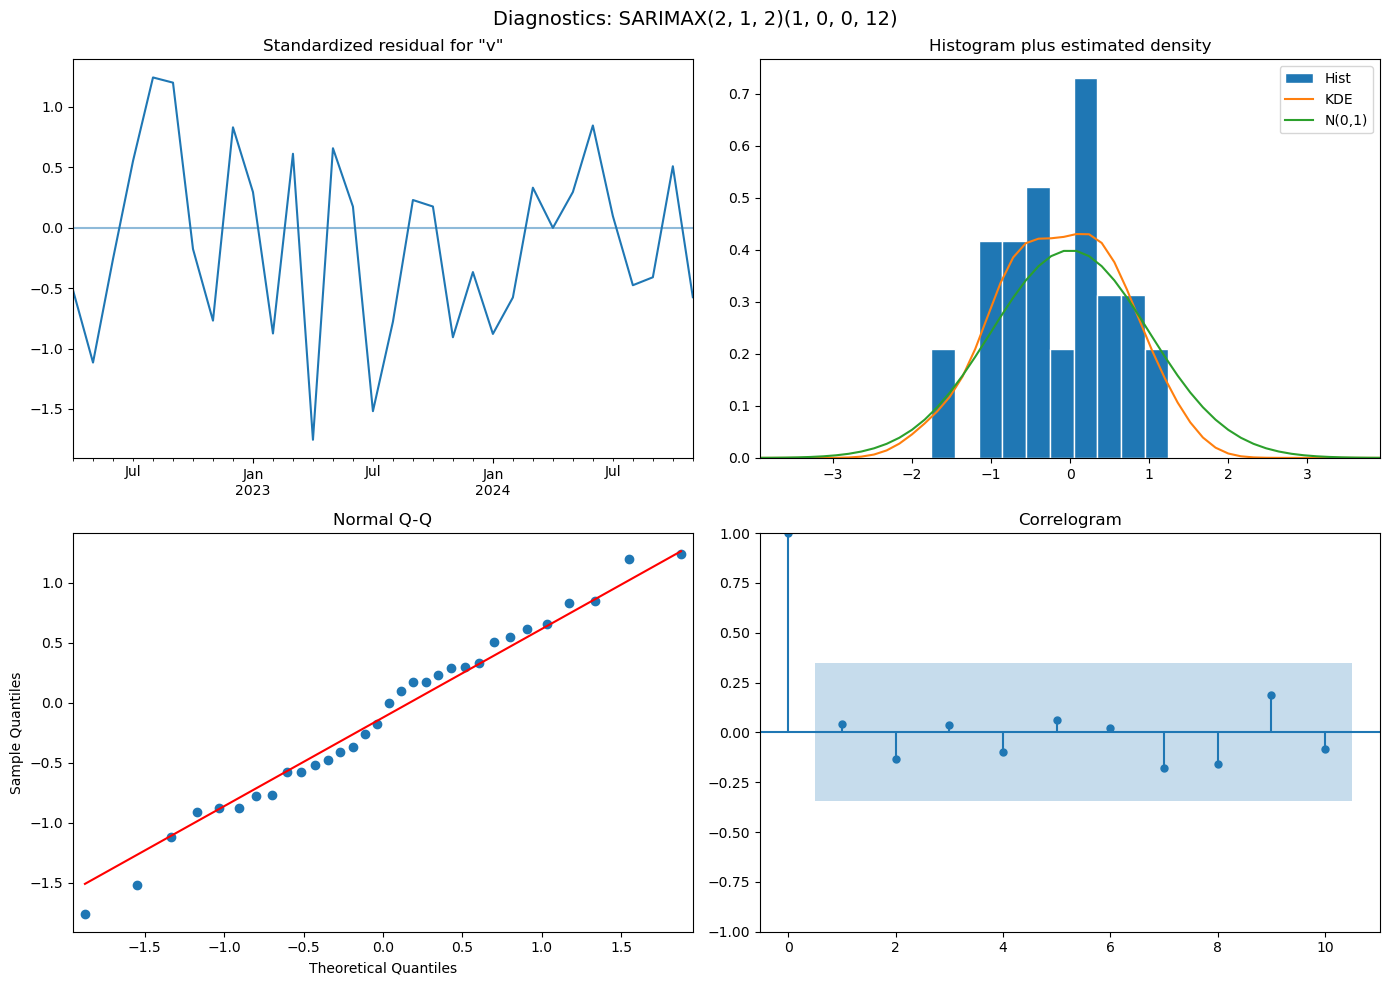

In [56]:
fig = best_fitted.plot_diagnostics(figsize=(14, 10))
plt.suptitle(f'Diagnostics: SARIMAX{best_order}{best_seasonal_order}', fontsize=14)
plt.tight_layout()
plt.show()

ljung box

In [57]:
# Ljung-Box Test
lb_test = acorr_ljungbox(best_fitted.resid, lags=[10, 20], return_df=True)
print("\nLjung-Box Test (Residual Autocorrelation):")
print(lb_test)

if (lb_test['lb_pvalue'] > 0.05).all():
    print("\nResidual tidak memiliki autokorelasi → Model OK!")
else:
    print("\nAda autokorelasi di residual → Model mungkin perlu diperbaiki")


Ljung-Box Test (Residual Autocorrelation):
     lb_stat  lb_pvalue
10  3.504668   0.966940
20  7.850649   0.992811

Residual tidak memiliki autokorelasi → Model OK!


## Forecast VS Actual

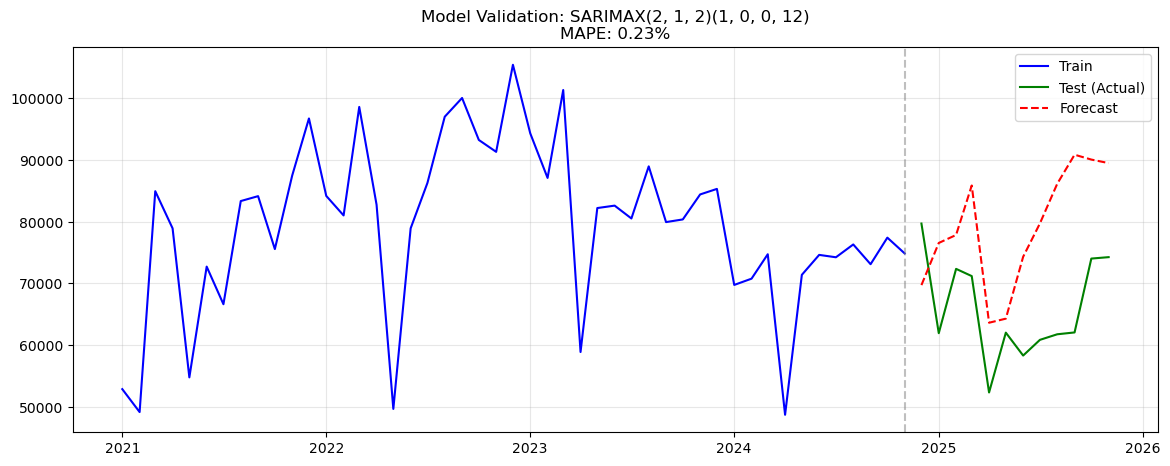

In [58]:
forecast_test = best_fitted.forecast(steps=len(test_y), exog=test_X)

plt.figure(figsize=(14, 5))
plt.plot(train_y.index, train_y, label='Train', color='blue')
plt.plot(test_y.index, test_y, label='Test (Actual)', color='green')
plt.plot(test_y.index, forecast_test, label='Forecast', color='red', linestyle='--')
plt.axvline(x=train_y.index[-1], color='gray', linestyle='--', alpha=0.5)
plt.title(f'Model Validation: SARIMAX{best_order}{best_seasonal_order}\nMAPE: {best_model_info["MAPE"]:.2f}%')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Final Model & Forecasting

re-fit semua model di data

In [59]:
df_all_featured = create_features(df.copy())
df_all_clean = impute_nan_with_train_params(df_all_featured, monthly_avg_train, overall_std_train)

# Fit model terbaik pada SEMUA data
final_y = df_all_clean['value']
final_X = df_all_clean[exog_columns]

print(f"Fitting final model pada {len(final_y)} observasi...")

final_model = SARIMAX(
    final_y,
    exog=final_X,
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
final_fitted = final_model.fit(disp=False)

print(f"\n✅ Final model fitted!")
print(f"   AIC: {final_fitted.aic:,.2f}")
print(f"   BIC: {final_fitted.bic:,.2f}")


Fitting final model pada 59 observasi...


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.




✅ Final model fitted!
   AIC: 929.81
   BIC: 958.35


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



# Recursive Forecasting

In [60]:
def recursive_forecast(fitted_model, historical_df, exog_columns, n_forecast, monthly_avg, overall_std):
    all_values = list(historical_df['value'].values)
    
    # generate future dates 
    last_date = historical_df.index[-1]
    future_dates = pd.date_range(
        start=last_date + pd.DateOffset(months=1),
        periods=n_forecast,
        freq='MS'
    )
    
    forecast = []
    lower_ci = []
    upper_ci = []
    
    for i in range(n_forecast):
        current_date = future_dates[i]
        current_month = current_date.month
        
        # exogenous untuk step ini 
        
        exog_dict = {}
        n_hist = len(all_values)
        
        # LAG FEATURES
        exog_dict['lag_1'] = all_values[-1] if n_hist >= 1 else monthly_avg.get(current_month, overall_std)
        exog_dict['lag_2'] = all_values[-2] if n_hist >= 2 else monthly_avg.get(current_month, overall_std)
        exog_dict['lag_3'] = all_values[-3] if n_hist >= 3 else monthly_avg.get(current_month, overall_std)
        exog_dict['lag_6'] = all_values[-6] if n_hist >= 6 else monthly_avg.get(current_month, overall_std)
        exog_dict['lag_12'] = all_values[-12] if n_hist >= 12 else monthly_avg.get(current_month, overall_std)
        exog_dict['lag_24'] = all_values[-24] if n_hist >= 24 else monthly_avg.get(current_month, overall_std)
        
        # ROLLING FEATURES
        exog_dict['rolling_mean_3'] = np.mean(all_values[-3:]) if n_hist >= 3 else monthly_avg.get(current_month, overall_std)
        exog_dict['rolling_std_3'] = np.std(all_values[-3:]) if n_hist >= 3 else overall_std
        exog_dict['rolling_mean_6'] = np.mean(all_values[-6:]) if n_hist >= 6 else monthly_avg.get(current_month, overall_std)
        exog_dict['rolling_std_6'] = np.std(all_values[-6:]) if n_hist >= 6 else overall_std
        exog_dict['rolling_mean_12'] = np.mean(all_values[-12:]) if n_hist >= 12 else monthly_avg.get(current_month, overall_std)
        exog_dict['rolling_std_12'] = np.std(all_values[-12:]) if n_hist >= 12 else overall_std
        
        # CYCLICAL FEATURES (dari tanggal)
        exog_dict['month_sin'] = np.sin(2 * np.pi * current_month / 12)
        exog_dict['month_cos'] = np.cos(2 * np.pi * current_month / 12)
        exog_dict['quarter_sin'] = np.sin(2 * np.pi * ((current_month - 1) // 3 + 1) / 4)
        exog_dict['quarter_cos'] = np.cos(2 * np.pi * ((current_month - 1) // 3 + 1) / 4)
        
        # SEASONAL INDICATORS (dari tanggal)
        quarter = (current_month - 1) // 3 + 1
        exog_dict['is_q1'] = 1 if quarter == 1 else 0
        exog_dict['is_q2'] = 1 if quarter == 2 else 0
        exog_dict['is_q3'] = 1 if quarter == 3 else 0
        exog_dict['is_q4'] = 1 if quarter == 4 else 0
        exog_dict['is_year_start'] = 1 if current_month <= 2 else 0
        exog_dict['is_year_end'] = 1 if current_month >= 11 else 0
        exog_dict['is_mid_year'] = 1 if current_month in [6, 7, 8] else 0
        
        # Buat DataFrame exog untuk step ini
        current_exog = pd.DataFrame([exog_dict], index=[current_date])[exog_columns]
        
        # forecast 1 step 
        fc_res = fitted_model.get_forecast(steps=1, exog=current_exog)
        fc_val = fc_res.predicted_mean.values[0]
        fc_ci = fc_res.conf_int()
        
        # simpan hasil 
        forecast.append(fc_val)
        lower_ci.append(fc_ci.iloc[0,0])
        upper_ci.append(fc_ci.iloc[0,1])
        
        # update all_values untuk step berikutnya 
        all_values.append(fc_val)
        
        # progress
        if (i+1) % 12 == 0:
            print(f" {i+1}/{n_forecast} periods completed ({(i+1)//12} tahun)")
    
    # dataframe hasil forecast
    forecast_df = pd.DataFrame({
        'Date' : future_dates,
        'Forecast': forecast,
        'Lower_CI': lower_ci,
        'Upper_CI': upper_ci })
    forecast_df.set_index('Date', inplace=True)
    return forecast_df

# Forecast untuk 1 Tahun 

In [61]:
forecast_1 = recursive_forecast(
    fitted_model=final_fitted,
    historical_df=df_all_clean,
    exog_columns=exog_columns,
    n_forecast=12,
    monthly_avg=monthly_avg_train,
    overall_std=overall_std_train
)

 12/12 periods completed (1 tahun)


In [62]:
print("Hasil Forecasting 1 Tahun ke depan:")
forecast_1

Hasil Forecasting 1 Tahun ke depan:


,Forecast,Lower_CI,Upper_CI
Date,,,
2025-12-01,75235.628522,59662.497816,90808.759228
2026-01-01,64907.231229,49334.100522,80480.361935
2026-02-01,69275.265746,53702.135040,84848.396452
2026-03-01,65205.628776,49632.498070,80778.759482
2026-04-01,53936.833469,38363.702763,69509.964175
2026-05-01,58793.059965,43219.929259,74366.190671
2026-06-01,59124.688867,43551.558161,74697.819573
2026-07-01,63672.416692,48099.285986,79245.547398
2026-08-01,63993.747186,48420.616480,79566.877892


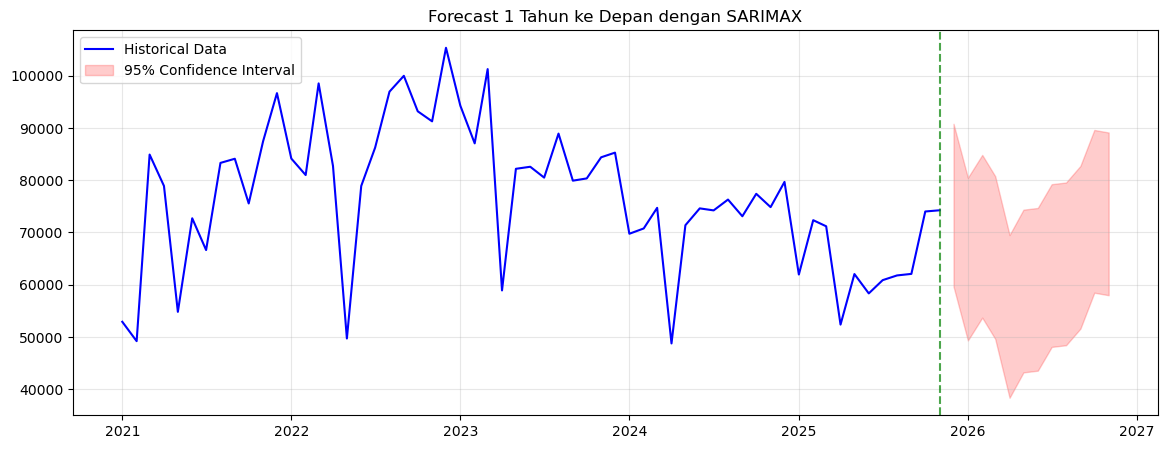

In [63]:
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['value'], label='Historical Data', color='blue')
plt.fill_between(forecast_1.index, forecast_1['Lower_CI'],
                 forecast_1['Upper_CI'], color='red', alpha=0.2, label='95% Confidence Interval')
plt.axvline(x=df.index[-1], color='green', linestyle='--', alpha=0.7)
plt.title('Forecast 1 Tahun ke Depan dengan SARIMAX')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

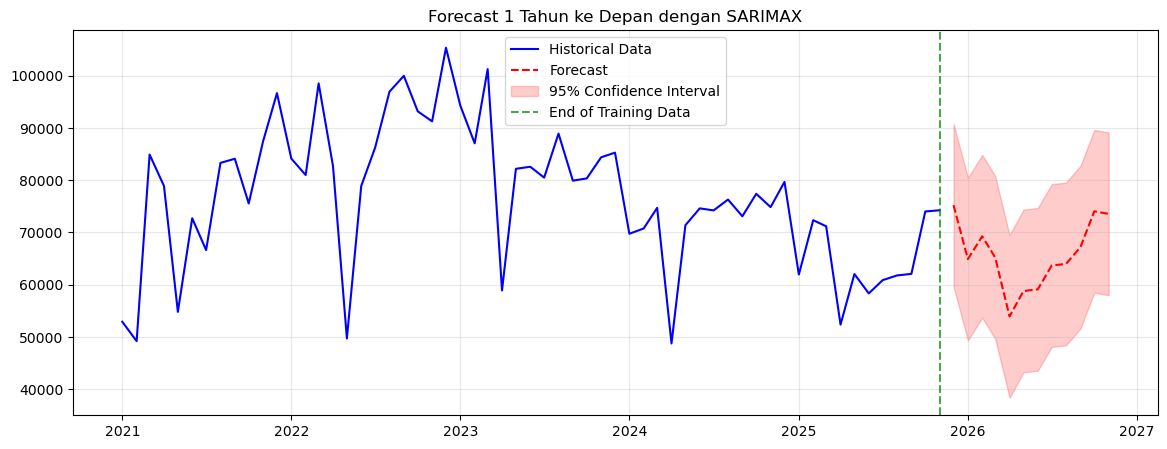

In [64]:
plt.figure(figsize=(14, 5))

# Data historis
plt.plot(df.index, df['value'],
         label='Historical Data',
         color='blue')

# Garis hasil forecast
plt.plot(forecast_1.index, forecast_1['Forecast'],
         label='Forecast',
         color='red',
         linestyle='--')

# Confidence Interval
plt.fill_between(
    forecast_1.index,
    forecast_1['Lower_CI'],
    forecast_1['Upper_CI'],
    color='red',
    alpha=0.2,
    label='95% Confidence Interval'
)

# Garis pemisah train & forecast
plt.axvline(x=df.index[-1],
            color='green',
            linestyle='--',
            alpha=0.7,
            label='End of Training Data')

plt.title('Forecast 1 Tahun ke Depan dengan SARIMAX')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# Forecast 5 Tahun

In [65]:
forecast_5 = recursive_forecast(
    fitted_model=final_fitted,
    historical_df=df_all_clean,
    exog_columns=exog_columns,
    n_forecast=60,
    monthly_avg=monthly_avg_train,
    overall_std=overall_std_train
)

 12/60 periods completed (1 tahun)
 24/60 periods completed (2 tahun)
 36/60 periods completed (3 tahun)
 48/60 periods completed (4 tahun)
 60/60 periods completed (5 tahun)


In [66]:
forecast_5.head(12)

,Forecast,Lower_CI,Upper_CI
Date,,,
2025-12-01,75235.628522,59662.497816,90808.759228
2026-01-01,64907.231229,49334.100522,80480.361935
2026-02-01,69275.265746,53702.135040,84848.396452
2026-03-01,65205.628776,49632.498070,80778.759482
2026-04-01,53936.833469,38363.702763,69509.964175
2026-05-01,58793.059965,43219.929259,74366.190671
2026-06-01,59124.688867,43551.558161,74697.819573
2026-07-01,63672.416692,48099.285986,79245.547398
2026-08-01,63993.747186,48420.616480,79566.877892


In [67]:
forecast_5.tail(12)

,Forecast,Lower_CI,Upper_CI
Date,,,
2029-12-01,70286.774614,54713.643908,85859.905320
2030-01-01,71244.066370,55670.935664,86817.197076
2030-02-01,66543.764301,50970.633595,82116.895007
2030-03-01,62715.609288,47142.478582,78288.739994
2030-04-01,54633.458619,39060.327913,70206.589325
2030-05-01,58884.386952,43311.256246,74457.517659
2030-06-01,60723.258567,45150.127861,76296.389273
2030-07-01,64159.672578,48586.541872,79732.803284
2030-08-01,64359.844216,48786.713510,79932.974922


visualisasi

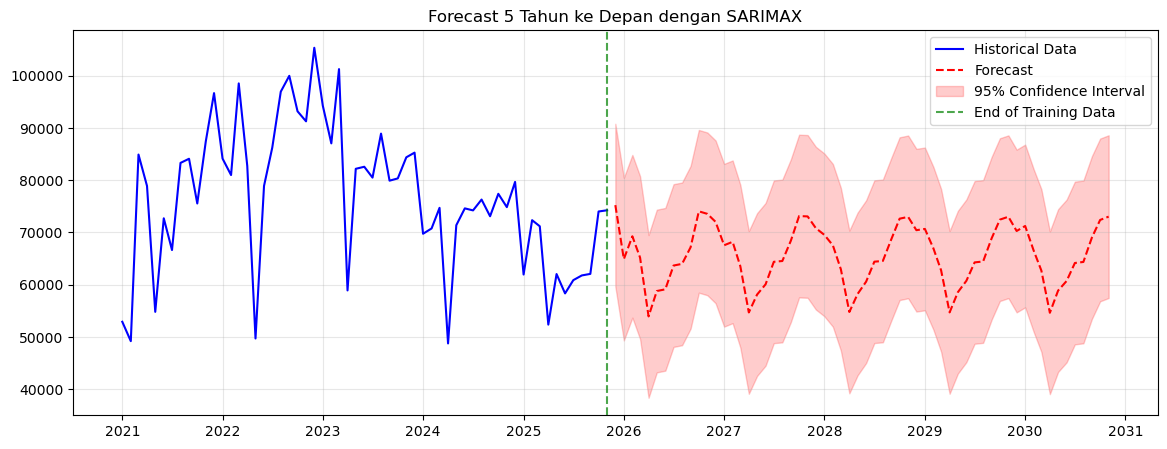

In [68]:
plt.figure(figsize=(14, 5))

# Data historis
plt.plot(
    df.index,
    df['value'],
    label='Historical Data',
    color='blue'
)

# Garis hasil forecast 5 tahun
plt.plot(
    forecast_5.index,
    forecast_5['Forecast'],
    label='Forecast',
    color='red',
    linestyle='--'
)

# Confidence Interval
plt.fill_between(
    forecast_5.index,
    forecast_5['Lower_CI'],
    forecast_5['Upper_CI'],
    color='red',
    alpha=0.2,
    label='95% Confidence Interval'
)

# Batas akhir data historis
plt.axvline(
    x=df.index[-1],
    color='green',
    linestyle='--',
    alpha=0.7,
    label='End of Training Data'
)

plt.title('Forecast 5 Tahun ke Depan dengan SARIMAX')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# Forecast 10 Tahun 

In [69]:
forecast_10 = recursive_forecast(
    fitted_model=final_fitted,
    historical_df=df_all_clean,
    exog_columns=exog_columns,
    n_forecast=120,
    monthly_avg=monthly_avg_train,
    overall_std=overall_std_train
)

 12/120 periods completed (1 tahun)
 24/120 periods completed (2 tahun)
 36/120 periods completed (3 tahun)
 48/120 periods completed (4 tahun)
 60/120 periods completed (5 tahun)
 72/120 periods completed (6 tahun)
 84/120 periods completed (7 tahun)
 96/120 periods completed (8 tahun)
 108/120 periods completed (9 tahun)
 120/120 periods completed (10 tahun)


In [70]:
forecast_10.head(12)

,Forecast,Lower_CI,Upper_CI
Date,,,
2025-12-01,75235.628522,59662.497816,90808.759228
2026-01-01,64907.231229,49334.100522,80480.361935
2026-02-01,69275.265746,53702.135040,84848.396452
2026-03-01,65205.628776,49632.498070,80778.759482
2026-04-01,53936.833469,38363.702763,69509.964175
2026-05-01,58793.059965,43219.929259,74366.190671
2026-06-01,59124.688867,43551.558161,74697.819573
2026-07-01,63672.416692,48099.285986,79245.547398
2026-08-01,63993.747186,48420.616480,79566.877892


In [71]:
forecast_10.tail(12)

,Forecast,Lower_CI,Upper_CI
Date,,,
2034-12-01,70018.909307,54445.778601,85592.040014
2035-01-01,71861.108646,56287.977940,87434.239352
2035-02-01,65999.650184,50426.519478,81572.780890
2035-03-01,62874.780037,47301.649331,78447.910743
2035-04-01,54433.234221,38860.103515,70006.364927
2035-05-01,59419.257913,43846.127207,74992.388619
2035-06-01,60383.815169,44810.684463,75956.945875
2035-07-01,64136.001551,48562.870845,79709.132257
2035-08-01,64204.765514,48631.634808,79777.896220


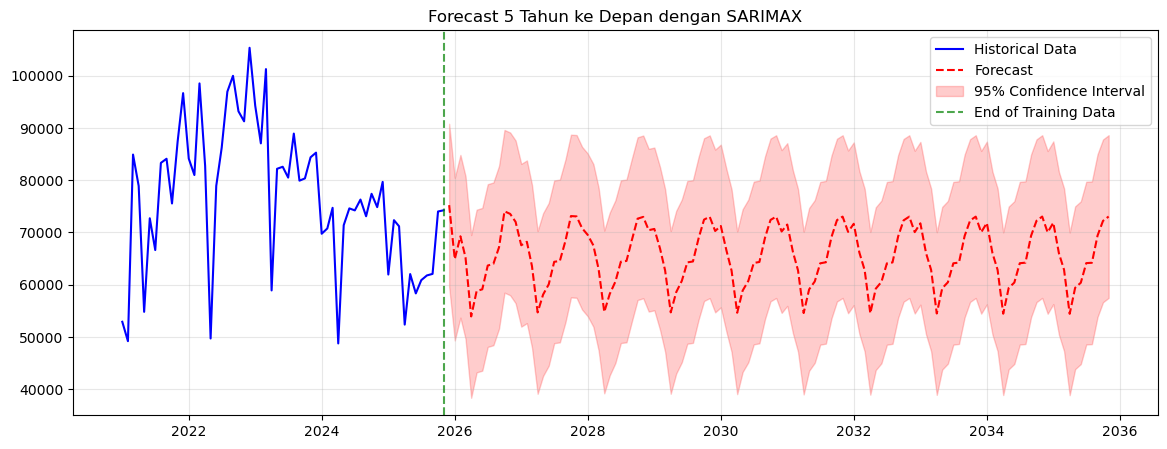

In [72]:
plt.figure(figsize=(14, 5))

# Data historis
plt.plot(
    df.index,
    df['value'],
    label='Historical Data',
    color='blue'
)

# Garis hasil forecast 5 tahun
plt.plot(
    forecast_10.index,
    forecast_10['Forecast'],
    label='Forecast',
    color='red',
    linestyle='--'
)

# Confidence Interval
plt.fill_between(
    forecast_10.index,
    forecast_10['Lower_CI'],
    forecast_10['Upper_CI'],
    color='red',
    alpha=0.2,
    label='95% Confidence Interval'
)

# Batas akhir data historis
plt.axvline(
    x=df.index[-1],
    color='green',
    linestyle='--',
    alpha=0.7,
    label='End of Training Data'
)

plt.title('Forecast 5 Tahun ke Depan dengan SARIMAX')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
